In [1]:
# basics
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# tools
import scipy
import math
import random
import sklearn
import string
from sklearn.model_selection import train_test_split


finalbooks = pd.read_csv('../../data/output csv files/finalbooks.csv')
ratings = pd.read_csv('../../data/output csv files/finalratings.csv')
train = pd.read_csv('../../data/output csv files/train.csv')
test = pd.read_csv('../../data/output csv files/test.csv')

In [2]:
## NDGC & RMSE

def dcg_k(r, k):
    """ Discounted Cumulative Gain (DGC)  
    Args:
        r: True Ratings in Predicted Rank Order (1st element is top recommendation)
        k: Number of results to consider
    Returns:
        DCG
    """
  
    r = np.asfarray(r)[:k]
    return np.sum(2**r / np.log2(np.arange(2, r.size + 2)))      



def ndcg_k(r, k):
    """Normalized Discounted Cumulative Gain (NDCG)
    Args:
        r: True Ratings in Predicted Rank Order (1st element is top recommendation)
        k: Number of results to consider
    Returns:
        NDCG
    """
    dcg_max = dcg_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_k(r, k) / dcg_max

def mean_ndcg(rs):
    """Mean NDCG for all users
    Args:
        rs: Iterator / For each user: True Ratings in Predicted Rank Order
    Returns:
        Mean NDCG
    """
    return np.mean([ndcg_k(r, len(r)) for r in rs])

def rmse(y,h):
    """RMSE
    Args:
        y: real y
        h: predicted y
    Returns:
        RMSE
    """
    a = y-h

    return np.sqrt(sum(a**2)/len(a))

In [3]:

# MATRIX FACTORIZATION
def new_R(data, U, B):
    nR = np.zeros(data.shape[0])
    c = 0
    for i in range(data.shape[0]):
        #if i % 10000000 == 0:
            #print('step ' + str(i))
        nR[c] = B[:, data.newbookid[i] - 1] @ U[data.newuser_id[i] - 1, :]

        c += 1
    return nR

In [4]:

def ALS(train, k, lamu = 0.1, lamb = 0.1):
    users = np.unique(train.newuser_id)
    books = np.unique(train.newbookid)
    nu = len(users)
    nb = len(books)

# Initialize U and B

    #U = np.random.rand(max(users), k)/50
    #B = np.random.rand(k, max(books))/50
    #B[0, books - 1] = finalbooks.average_rating[books - 1]

    U = np.ones((max(users), k)) / np.sqrt(k)
    B = np.ones((k, max(books))) / np.sqrt(k)
    #B[0, books - 1] = finalbooks.average_rating[books - 1]
    
    iter = 1
    RMSE = 3
    dRMSE = 1
    rms = []
    stop = 0.0001
    max_iter = 24
    
    while (dRMSE > stop) and (iter < max_iter):
      for i in users:
        ind_B = train.newbookid[train.newuser_id == i] - 1
        sub_B = B[:, ind_B]
        nui = sub_B.shape[1]
        Ai = sub_B @ np.transpose(sub_B) + lamu * np.identity(k)  #*nui
        Vi = sub_B @ train.rating[train.newuser_id == i]
        U[i - 1, :] = np.linalg.pinv(Ai) @ Vi
        #if i % 1000 == 0: print('user ' + str(i))
      nR = new_R(train, U, B)
      new_RMSE = rmse(nR,train.rating)
      dRMSEu = (RMSE - new_RMSE)
      RMSE = new_RMSE.copy()
      #print('dRMSE = ' + str(dRMSE))
      rms.append(RMSE)
      iter += 1
      print("step: ", iter)

      for i in books:
        ind_U = train.newuser_id[train.newbookid == i] - 1
        sub_U = U[ind_U, :]
        nbi = sub_U.shape[0]
        Ai = np.transpose(sub_U) @ sub_U + lamb * np.identity(k)   #*nbi
        Vi = np.transpose(sub_U) @ train.rating[train.newbookid == i]
        B[:, i - 1] = np.linalg.pinv(Ai) @ Vi
        #if i % 1000 == 0: print('book ' + str(i))
      nR = new_R(train, U, B)
      new_RMSE = rmse(nR,train.rating)
      dRMSE = (RMSE - new_RMSE) #np.abs
      #dRMSE = min(dRMSEu, dRMSEb) #np.abs
      RMSE = new_RMSE.copy()
      #print('dRMSE = ' + str(dRMSE))
      #print('RMSE = ' + str(RMSE))
      print("step: ", iter)
      rms.append(RMSE)
      iter += 1
    w = {}
    w['rms'] = rms
    w['U'] = U
    w['B'] = B

    return w

In [5]:
traint, traincv = train_test_split(train,
                               stratify=train['newuser_id'], 
                               test_size=0.1875,
                               random_state=42)
traint = traint.reset_index(drop=True)
traincv = traincv.reset_index(drop=True)

In [6]:
ks = []
trains = []
cvs = []
ndgs = []

for k in [3]:
  for alphau in  [ 0.125]:
    for betab in  [0.075, 0.1, 0.2, 1]:
      print("running for... alphau = ", alphau, " and betab = ", betab)
      w = ALS(traint, k, alphau, betab)
      CVpred = new_R(traincv, w['U'], w['B'])
      RMSE_CV = np.sqrt(np.mean((CVpred - traincv.rating) ** 2))
      ranked = traincv.filter(['rating'])
      ranked['pred'] = CVpred
      ndgcv = ndcg_k(ranked.sort_values(by=['pred'], ascending = False).rating, len(ranked.sort_values(by=['pred'], ascending = False).rating))
      ndgs.append(ndgcv)
      ks.append(betab)
      trains.append(w['rms'][-1])
      cvs.append(RMSE_CV)
      print("RMSEtrain: ", w['rms'][-1])
      print("RMSECV: ", RMSE_CV)
      print("done for: k= ", k, "alphau= ", alphau, "betab= ", betab)
      print("RMSEtrain: ", w['rms'][-1])
      print("RMSECV: ", RMSE_CV)
      print("NDG: ", ndgcv)
      print ("w rms: ", w['rms'])

running for... alphau =  0.125  and betab =  0.075
step:  2
step:  2
step:  4
step:  4
step:  6
step:  6
RMSEtrain:  0.8708288399171024
RMSECV:  0.8830296671206759
done for: k=  3 alphau=  0.125 betab=  0.075
RMSEtrain:  0.8708288399171024
RMSECV:  0.8830296671206759
NDG:  0.9786237377980047
w rms:  [0.9176373568466061, 0.8728877462165853, 0.8711109931200388, 0.8709069270758304, 0.8708977137250491, 0.8708288399171024]
running for... alphau =  0.125  and betab =  0.1
step:  2
step:  2
step:  4
step:  4
step:  6
step:  6
RMSEtrain:  0.8708603484383786
RMSECV:  0.8830455226957235
done for: k=  3 alphau=  0.125 betab=  0.1
RMSEtrain:  0.8708603484383786
RMSECV:  0.8830455226957235
NDG:  0.9786226939616115
w rms:  [0.9176373568466061, 0.8728877879838463, 0.8711108156623435, 0.8709069372055328, 0.8708977010919403, 0.8708603484383786]
running for... alphau =  0.125  and betab =  0.2
step:  2
step:  2
step:  4
step:  4
step:  6
step:  6
RMSEtrain:  0.8708701214226839
RMSECV:  0.88304813552929


In [7]:
print(ks)
print(trains)
print(cvs)

[0.075, 0.1, 0.2, 1]
[0.8708288399171024, 0.8708603484383786, 0.8708701214226839, 0.870879272367362]
[0.8830296671206759, 0.8830455226957235, 0.88304813552929, 0.8830365387939213]


In [9]:
w = ALS(train,  3, 0.1, 0.1)

step:  2
step:  2
step:  4
step:  4
step:  6
step:  6
step:  8
step:  8
step:  10
step:  10
step:  12
step:  12
step:  14
step:  14
step:  16
step:  16
step:  18
step:  18
step:  20
step:  20
step:  22
step:  22
step:  24
step:  24


In [10]:
R = w['U'].dot(w['B'])

In [11]:
rflat = np.matrix.flatten(R)
testy = np.repeat(np.array(train.newuser_id.unique()), 8000)
booky = np.tile(np.array(finalbooks.newbookid), 15000)
booky.size

120000000

In [12]:
testy = np.sort(testy)
testy.size

120000000

In [13]:
rflat.size

120000000

In [14]:
predictions = pd.DataFrame(np.column_stack((testy, booky, rflat)), columns=('newuser_id','newbookid', 'pred'))
predictions

,newuser_id,newbookid,pred
0,1.0,1.0,4.175611
1,1.0,2.0,4.215383
2,1.0,3.0,4.456223
3,1.0,4.0,4.462765
4,1.0,5.0,3.598506
...,...,...,...
119999995,15000.0,7996.0,3.782936
119999996,15000.0,7997.0,3.803706
119999997,15000.0,7998.0,3.320146
119999998,15000.0,7999.0,4.027040


In [15]:
predictions.to_csv( 'predictions.csv' , index = False )

In [6]:
import time
from dask import dataframe as dd
start = time.time()
predictions = dd.read_csv('predictions.csv')
end = time.time()

In [7]:
## DEFINING THE TAIL
tailcomp = ratings.groupby(by= 'newbookid', as_index=False).agg({'rating':pd.Series.count}).sort_values(by = 'rating', ascending = False)
tot = sum(tailcomp['rating'])
tailcomp['popshare']= [x/tot for x in tailcomp['rating']]
tailcomp['popshare']= tailcomp['popshare'].cumsum()
tailcomp['category']= ['Head' if x<0.95 else "Tail" for x in tailcomp['popshare']]

tail = tailcomp.loc[tailcomp.popshare >= 0.95]
tail

,newbookid,rating,popshare,category
5458,6115,35,0.950003,Tail
4776,5341,35,0.950036,Tail
4154,4641,35,0.950069,Tail
5735,6433,35,0.950103,Tail
6180,6945,35,0.950136,Tail
...,...,...,...,...
1643,1775,1,0.999996,Tail
6510,7309,1,0.999997,Tail
4748,5310,1,0.999998,Tail
1688,1824,1,0.999999,Tail


In [10]:
test = dd.read_csv('test.csv')
test

,rating,newbookid,newuser_id
npartitions=1,,,
,int64,int64,int64
,...,...,...


In [11]:
mfrank = test.merge(predictions,on = ['newbookid', 'newuser_id'])
#mfrank = mfrank.sort_values(by=['newuser_id', 'pred'], ascending=False)
mfrank = mfrank.nlargest(columns= ['newuser_id','pred'])
mfrank.head(5)

,rating,newbookid,newuser_id,pred
4381,5,4320,15000,5.265769
3302,5,1010,15000,5.180149
1606,4,89,15000,4.792185
1227,4,102,15000,4.776845
4423,4,70,15000,4.746692


In [29]:
#train['conc']=train['newuser_id'].map(str)+train['newbookid'].map(str)
#pred['conc']=pred['newuser_id'].map(str)+pred['newbookid'].map(str)
#predfin = pred[~pred.conc.isin(train.conc)]
#predfin.describe()

In [12]:
mfr = mfrank.compute()

In [13]:
mflist = []
for i in range(15000):
    a = mfr.loc[mfr.newuser_id == i+1]['rating'].tolist()
    mflist.append(a)
    if (i+1)%1000 == 0: print("done: ", i+1)

done:  1000
done:  2000
done:  3000
done:  4000
done:  5000
done:  6000
done:  7000
done:  8000
done:  9000
done:  10000
done:  11000
done:  12000
done:  13000
done:  14000
done:  15000


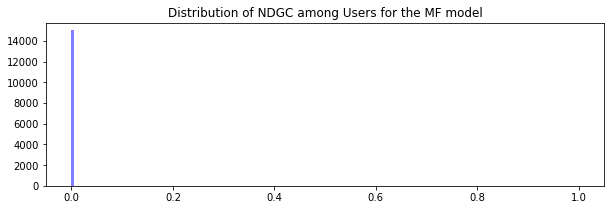

In [14]:
b = np.array([ndcg_k(r, len(r)) for r in mflist])


facet, axes = plt.subplots(1, 1, figsize=(10, 3))
n, bins, patches = plt.hist(b, 200, facecolor='blue', alpha=0.5) #, log = True)   
plt.title('Distribution of NDGC among Users for the MF model')
plt.show()

# [ndcg_k(r, len(r)) for r in poplista]

In [15]:
d = b[b == 1]
sum(d)/15000

6.666666666666667e-05

In [16]:
top10 = predictions.nlargest(n=10, columns='newuser_id')
top50 = predictions.nlargest(n=50, columns='newuser_id')
#top10 = predictions.sort_values('pred',ascending = False).groupby('newuser_id').head(10)
#top50 = predictions.sort_values('pred',ascending = False).groupby('newuser_id').head(50)

print('(1) MF Model RMSE: ', np.round(rmse(mfrank['pred'],mfrank['rating']), decimals=3))
print('(2) MF Model NDCG: ', np.round(mean_ndcg(mflist), decimals=3))
print("(2) Median NDCG: ", np.round(np.median(b), decimals=3))
print("(2) Share of NDCG =1 among Users: ", np.round(sum(d)/15000, decimals=3))
print('(3) MF Model Div10 Score: ',np.round(sum(np.in1d(top10.newbookid, tail.newbookid))/len(top10), decimals=3))
print('(3) MF Model Div50 Score: ',np.round(sum(np.in1d(top50.newbookid, tail.newbookid))/len(top50), decimals=3))

(1) MF Model RMSE:  0.615
(2) MF Model NDCG:  0.0
(2) Median NDCG:  0.0
(2) Share of NDCG =1 among Users:  0.0
(3) MF Model Div10 Score:  0.0
(3) MF Model Div50 Score:  0.0


In [17]:
train = dd.read_csv('test.csv')
train

,rating,newbookid,newuser_id
npartitions=1,,,
,int64,int64,int64
,...,...,...


In [18]:
mfranktrain = train.merge(predictions,on = ['newbookid', 'newuser_id'])
#mfranktrain = mfranktrain.sort_values(by=['newuser_id', 'pred'], ascending=False)
mfranktrain = mfranktrain.nlargest(columns= ['newuser_id','pred'])

In [19]:
mfrt = mfranktrain.compute()

In [20]:
mflisttrain = []
for i in range(15000):
    a = mfrt.loc[mfrt.newuser_id == i+1]['rating'].tolist()
    mflisttrain.append(a)
    if (i+1)%1000 == 0: print("done: ", i+1)

done:  1000
done:  2000
done:  3000
done:  4000
done:  5000
done:  6000
done:  7000
done:  8000
done:  9000
done:  10000
done:  11000
done:  12000
done:  13000
done:  14000
done:  15000


In [21]:
print('(1) MF Train Model RMSE: ', np.round(rmse(mfrt['pred'],mfrt['rating']), decimals=3))
print('(2) MF Train Model NDCG: ', np.round(mean_ndcg(mflisttrain), decimals=3))

(1) MF Train Model RMSE:  0.615
(2) MF Train Model NDCG:  0.0
